<a href="https://colab.research.google.com/github/kithian/inteligencia_artificial/blob/main/E4_Segmentacion_2025__.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Evaluación 4

**Integrantes:**

+ Integrante 1: Jose Hormazabal : jose.hormazabal2201@alumnos.ubiobio.cl
+ Integrante 2: David Parraguez : david.parraguez2201@alumnos.ubiobio.cl
+ Integrante 3: Christian Retamal : christian.retamal2201@alumnos.ubiobio.cl

**Fecha de Entrega:** 18 Diciembre 2025 antes de las 18:00  


---

## Descripción

Este notebook contiene el desarrollo de la evaluación 4 de la asignatura de Inteligencia Artificial de la carrera Ingeniería Civil en Informática de la Universidad del Biío Bío - Sede Concepción

---

## Requisitos de Software

Este notebook fue desarrollado con Python 3.X. A continuación se listan las bibliotecas necesarias:

pandas (>=1.1.0)

numpy (2.0.2)

matplotlib (3.10.0)

seaborn (0.13.2)

sklearn (1.6.1)

kneed (0.8.5)

In [3]:
!pip install kneed

## Parte 1: Modelo usando el CSV dado

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score

from kneed import KneeLocator

In [ ]:
url = "https://raw.githubusercontent.com/davidparraguez1809/inteligencia-artificial/refs/heads/main/clima_biobio.csv"
df = pd.read_csv(url)
df.head()

,Unnamed: 0,date,temperature_2m,relative_humidity_2m,apparent_temperature,precipitation_probability,uv_index,is_day
0,0,2024-12-09 00:00:00+00:00,14.737500,64.0,12.097788,NaN,0.25,1.0
1,1,2024-12-09 01:00:00+00:00,13.687500,69.0,11.469311,NaN,0.00,0.0
2,2,2024-12-09 02:00:00+00:00,13.087501,72.0,11.046282,NaN,0.00,0.0
3,3,2024-12-09 03:00:00+00:00,12.737500,72.0,10.625299,NaN,0.00,0.0
4,4,2024-12-09 04:00:00+00:00,12.387500,73.0,10.344244,NaN,0.00,0.0


In [ ]:
num_features = [
    "temperature_2m",
    "relative_humidity_2m",
    "apparent_temperature",
    "precipitation_probability",
    "uv_index",
    "is_day"
]



Al seleccionar las variables numéricas, dejamos de lado la variable sin nombre, puesto que es solo un índice. También, olvidamos la variable de "date" ya que no es numérica directamente. Con esto evitamos incluir variables que no aportan información o que podrían romper el modelo.

In [ ]:
# Pipeline para variables numericas
numeric_pipeline = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

La variable precipitation_probability presenta valores faltantes en aproximadamente la mitad de los registros. Para evitar la pérdida de información y mantener la consistencia del modelo, se realizó una imputación por mediana dentro del pipeline, garantizando un tratamiento uniforme tanto en entrenamiento como en predicción.

In [ ]:
# Column Transformer
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_pipeline, num_features)
    ]
)

In [ ]:
# Preprocesar datos
X = df[num_features]
X_scaled = preprocessor.fit_transform(X)

In [ ]:
# Seleccion de k
sse = []

for k in range(2, 21):
    kkmeans = KMeans(
        n_clusters=k,
        n_init="auto",
        random_state=29
    ).fit(X_scaled)

    sse.append(kkmeans.inertia_)

kl = KneeLocator(
    range(2, 21),
    sse,
    curve="convex",
    direction="decreasing"
)

print("El codo está en k =", kl.elbow)
print(f"El SSE = {np.round(kl.all_elbows_y, 2)}")

El codo está en k = 7
El SSE = [11483.02]


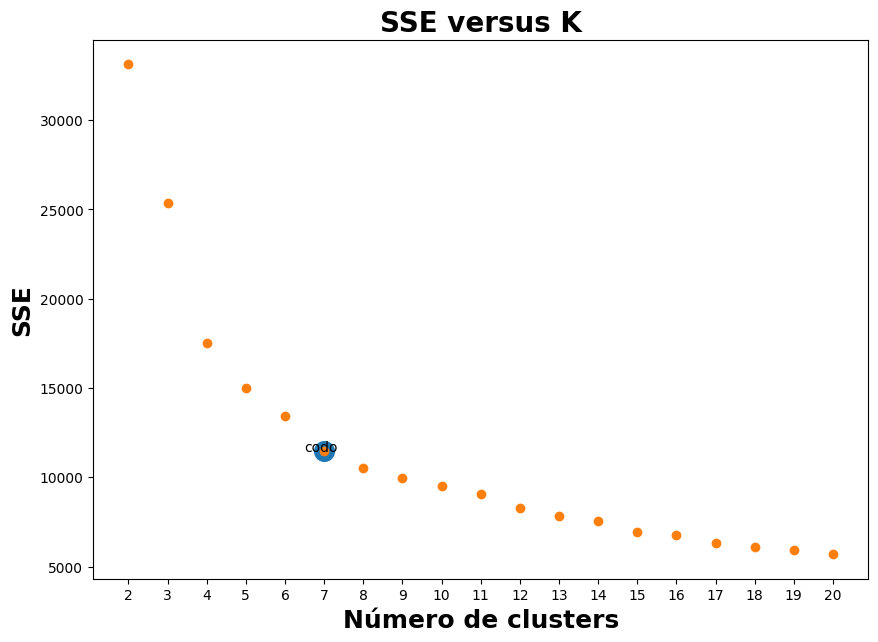

In [ ]:
# Gráfica
fig, ax = plt.subplots(figsize=(10, 7))

ax.scatter(kl.elbow, sse[kl.elbow - 2], s=200)
ax.text(kl.elbow - .5, sse[kl.elbow - 2] - 50, s="codo")

ax.scatter(range(2, 21), sse)
ax.set_xticks(range(2, 21))
ax.set_xlabel("Número de clusters", fontsize=18, fontweight="bold")
ax.set_ylabel("SSE", fontsize=18, fontweight="bold")
plt.title("SSE versus K", fontsize=20, fontweight="bold")
plt.show()

In [ ]:
# Construcción del modelo
kmeans_final = KMeans(
    n_clusters=kl.elbow,
    n_init="auto",
    random_state=29
)

X = df[num_features]
X_scaled = preprocessor.fit_transform(X)

clusters = kmeans_final.fit_predict(X_scaled)
df["cluster"] = clusters

In [ ]:
# Silhouette Score
silhouette = silhouette_score(X_scaled, clusters)
print(f"Silhouette Score: {silhouette:.4f}")

Silhouette Score: 0.3226


El silhouette score obtenido fue de 0.3226, lo cual indica una segmentación de calidad moderada. Este valor sugiere que, si bien los clusters presentan cierta coherencia interna, existe solapamiento entre ellos, lo cual es esperable en datos climáticos donde las transiciones entre condiciones meteorológicas suelen ser graduales y no discretas.

In [ ]:
# Obtención de centroides
centroides_scaled = kmeans_final.cluster_centers_

centroides_originales = preprocessor.named_transformers_["num"] \
    .named_steps["scaler"] \
    .inverse_transform(centroides_scaled)

df_centroides = pd.DataFrame(
    centroides_originales,
    columns=num_features
).round(2)

df_centroides["cluster"] = range(kl.elbow)
df_centroides

,temperature_2m,relative_humidity_2m,apparent_temperature,precipitation_probability,uv_index,is_day,cluster
0,10.85,85.61,8.47,1.25,0.00,0.00,0
1,17.46,67.32,16.31,-0.00,2.54,0.94,1
2,12.40,88.07,8.48,75.73,0.37,0.40,2
3,14.33,80.99,13.12,0.49,5.87,1.00,3
4,13.80,86.54,12.97,0.87,0.01,-0.00,4
5,21.43,52.36,20.99,-0.00,6.96,1.00,5
6,12.34,83.24,10.33,1.67,1.39,1.00,6


Algunos centroides presentan valores cercanos a cero con signo negativo debido a efectos de precisión numérica, los cuales se interpretan como valores nulos.

**Caracteristicas de clusters:**

Cluster 0:
*   Temperatura baja
*   Humedad alta
*   Sensación térmica baja
*   UV = 0
*   Noche (is_day = 0)

Días fríos, húmedos y nocturnos, sin radiación solar y sin precipitación significativa.

Cluster 1:
*   Temperatura moderada
*   Humedad media
*   Algo de radiación UV
*   Mayormente de día

Días templados y relativamente secos, con condiciones climáticas estables y baja probabilidad de lluvia.

Cluster 2:
*   Temperatura baja
*   Humedad muy alta
*   Alta probabilidad de precipitación
*   Poco UV
*   Día/noche mixto

Días fríos y muy húmedos, con alta probabilidad de precipitación, típicos de condiciones lluviosas o inestables.

Cluster 3:
*   Temperatura moderada
*   Humedad alta
*   UV alto
*   Día

Días templados, húmedos y soleados, con presencia significativa de radiación solar.

Cluster 4:
*   Temperatura moderada
*   Humedad alta
*   Muy baja precipitación
*   UV casi nulo

Días templados y húmedos, pero con baja radiación solar y condiciones estables.

Cluster 5:
*   Temperatura más alta
*   Humedad baja
*   UV alto
*   Día

Días cálidos, secos y soleados, con alta radiación UV y condiciones ideales de estabilidad atmosférica.

Cluster 6:
*   Temperatura baja
*   Humedad alta
*   UV bajo
*   Día

Días frescos y húmedos, con baja radiación solar y condiciones climáticas suaves.

**Interpretación de uno de los clusters:**

El cluster 5 es climáticamente extremo y tiene implicaciones claras.

Este representa días caracterizados por altas temperaturas, baja humedad relativa, ausencia de precipitación y un índice UV elevado. Este tipo de condiciones climáticas resulta especialmente relevante para sectores como el turismo y la planificación de actividades al aire libre, ya que corresponde a días soleados y estables. No obstante, también implica riesgos asociados a la exposición prolongada al sol, por lo que es importante considerar medidas preventivas como protección solar y gestión de horarios. Asimismo, este cluster puede ser de interés para la generación de energía solar, dado el alto nivel de radiación disponible.

La visualización de los clusters mediante PCA muestra una separación parcial entre grupos, con solapamientos especialmente en clusters intermedios. Este comportamiento es consistente con la naturaleza continua de los datos climáticos, donde las condiciones meteorológicas presentan transiciones graduales más que fronteras discretas. La presencia de clusters más claramente diferenciados, como aquellos asociados a días cálidos y soleados o a días fríos y lluviosos, valida la utilidad práctica del modelo a pesar de un silhouette score moderado.

La gráfica puede confirmar visualmente el silhouette:


*   No hay caos -> silhouette > 0.25
*   No hay separación perfecta -> silhouette < 0.5
*   Hay estructura + solapamiento -> silhouette = 0.32 aproximadamente


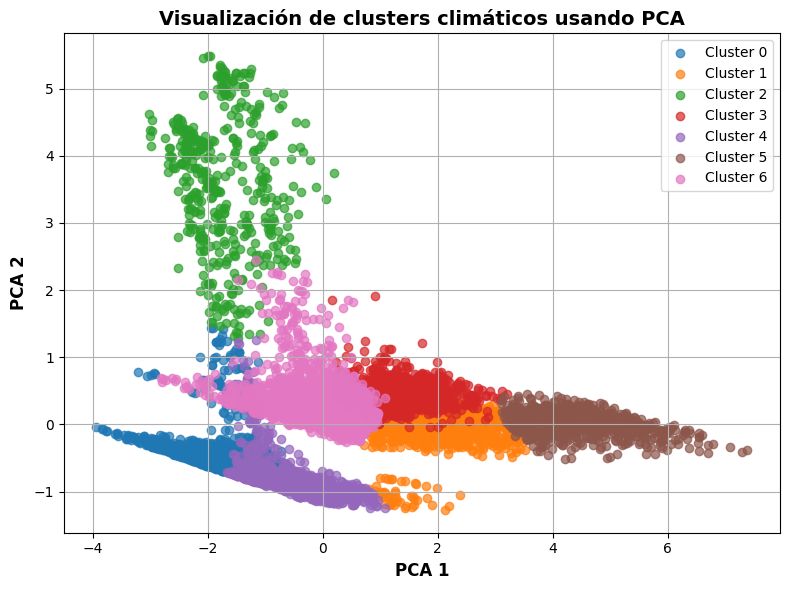

In [ ]:
# Grafica de clusters con PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

df["pca1"] = X_pca[:, 0]
df["pca2"] = X_pca[:, 1]

plt.figure(figsize=(8,6))

for cluster in sorted(df["cluster"].unique()):
    subset = df[df["cluster"] == cluster]
    plt.scatter(
        subset["pca1"],
        subset["pca2"],
        label=f"Cluster {cluster}",
        alpha=0.7
    )

plt.title("Visualización de clusters climáticos usando PCA", fontsize=14, fontweight="bold")
plt.xlabel("PCA 1", fontsize=12, fontweight="bold")
plt.ylabel("PCA 2", fontsize=12, fontweight="bold")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
# Predicion con datos nuevos

nuevo_dia = pd.DataFrame({
    "temperature_2m": [30],
    "relative_humidity_2m": [55],
    "apparent_temperature": [33],
    "precipitation_probability": [np.nan],  # puede tener NaN
    "uv_index": [8],
    "is_day": [1]
})

nuevo_scaled = preprocessor.transform(nuevo_dia)

cluster_predicho = kmeans_final.predict(nuevo_scaled)

print(f"El nuevo día pertenece al cluster {cluster_predicho[0]}")

El nuevo día pertenece al cluster 5


De acuerdo con el modelo de segmentación, el nuevo día presenta características similares a los días del cluster 5, los cuales corresponden a condiciones cálidas, secas y con alta radiación solar.

# Parte 2

In [14]:
url = "https://raw.githubusercontent.com/kithian/inteligencia_artificial/refs/heads/main/open-meteo-33.43S70.64W549m.csv"
df2 = pd.read_csv(url)
df2.head()

,time,temperature_2m (°C),relative_humidity_2m (%),precipitation (mm)
0,2023-01-01T00:00,18.6,65,0.0
1,2023-01-01T01:00,17.5,71,0.0
2,2023-01-01T02:00,15.9,77,0.0
3,2023-01-01T03:00,15.2,80,0.0
4,2023-01-01T04:00,14.5,82,0.0


In [15]:
num_features = [
    "temperature_2m (°C)",
    "relative_humidity_2m (%)",
    "precipitation (mm)"
]


Esta vez el modelo solo tiene 3 variables que hemos seleccionado, adicional la variable time no la consideramos, ya que no es una variable numerica

In [16]:
# Pipeline para variables numericas
numeric_pipeline = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

En este caso el csv no contiene valores "nan", pero igual se imputa por mediana por si existe algun valor invalido.

In [17]:
# Column Transformer
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_pipeline, num_features)
    ]
)

In [18]:
# Preprocesar datos
X2 = df2[num_features]
X2_scaled = preprocessor.fit_transform(X2)

In [20]:
# Seleccion de k
sse = []

for k in range(2, 21):
    kkmeans = KMeans(
        n_clusters=k,
        n_init="auto",
        random_state=29
    ).fit(X2_scaled)

    sse.append(kkmeans.inertia_)

kl = KneeLocator(
    range(2, 21),
    sse,
    curve="convex",
    direction="decreasing"
)

print("El codo está en k =", kl.elbow)
print(f"El SSE = {np.round(kl.all_elbows_y, 2)}")

El codo está en k = 6
El SSE = [3824.26]


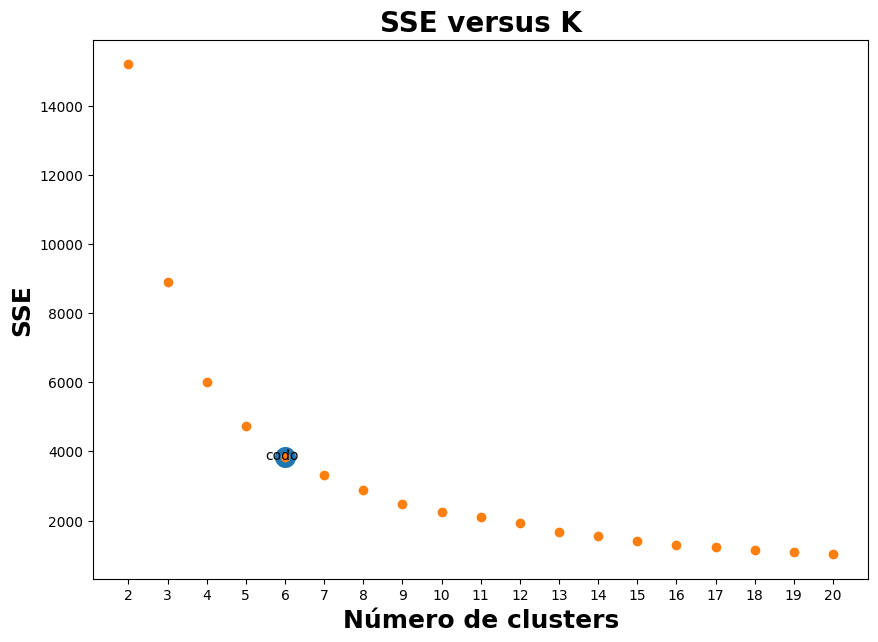

In [21]:
# Gráfica
fig, ax = plt.subplots(figsize=(10, 7))

ax.scatter(kl.elbow, sse[kl.elbow - 2], s=200)
ax.text(kl.elbow - .5, sse[kl.elbow - 2] - 50, s="codo")

ax.scatter(range(2, 21), sse)
ax.set_xticks(range(2, 21))
ax.set_xlabel("Número de clusters", fontsize=18, fontweight="bold")
ax.set_ylabel("SSE", fontsize=18, fontweight="bold")
plt.title("SSE versus K", fontsize=20, fontweight="bold")
plt.show()

In [22]:
# Construcción del modelo
kmeans_final = KMeans(
    n_clusters=kl.elbow,
    n_init="auto",
    random_state=29
)

X2 = df2[num_features]
X2_scaled = preprocessor.fit_transform(X2)

clusters = kmeans_final.fit_predict(X2_scaled)
df2["cluster"] = clusters

In [23]:
# Silhouette Score
silhouette = silhouette_score(X2_scaled, clusters)
print(f"Silhouette Score: {silhouette:.4f}")

Silhouette Score: 0.4083


El Silhouette Score obtenido fue de 0.4083, lo cual indica una segmentación de calidad moderada con tendencia a aceptable. Este valor refleja que el modelo ha logrado identificar patrones estructurales en los datos climáticos; no obstante, la proximidad al umbral de 0.5 sugiere la presencia de zonas de solapamiento. Esto es consistente con la naturaleza de las variables meteorológicas, cuyas fronteras suelen ser difusas, indicando que, aunque los grupos son identificables, existen observaciones en los límites de transición entre un estado climático y otro.

In [24]:
# Obtención de centroides
centroides_scaled = kmeans_final.cluster_centers_

centroides_originales = preprocessor.named_transformers_["num"] \
    .named_steps["scaler"] \
    .inverse_transform(centroides_scaled)

df2_centroides = pd.DataFrame(
    centroides_originales,
    columns=num_features
).round(2)

df2_centroides["cluster"] = range(kl.elbow)
df2_centroides

,temperature_2m (°C),relative_humidity_2m (%),precipitation (mm),cluster
0,11.15,84.17,0.02,0
1,28.03,28.03,0.00,1
2,11.23,87.22,1.42,2
3,19.77,44.31,0.00,3
4,11.54,86.67,4.29,4
5,14.75,61.84,0.00,5


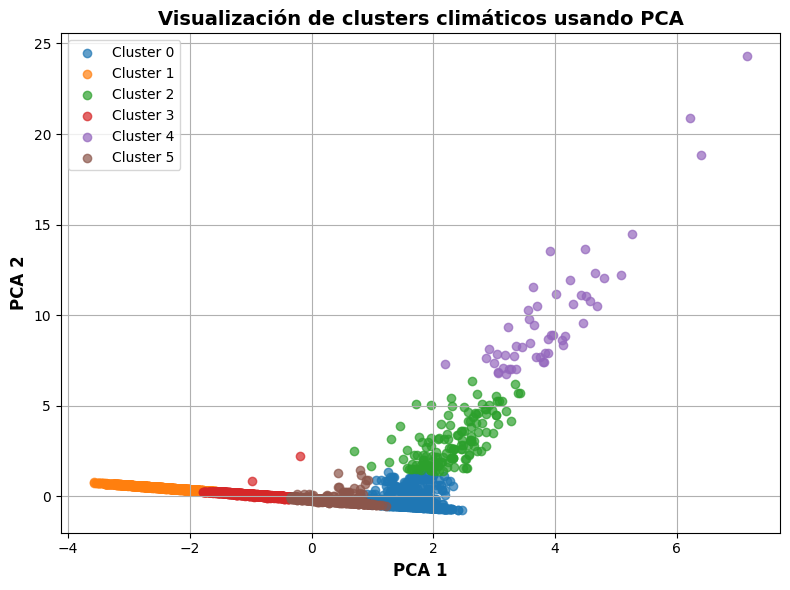

In [25]:
# Grafica de clusters con PCA
pca = PCA(n_components=2)
X2_pca = pca.fit_transform(X2_scaled)

df2["pca1"] = X2_pca[:, 0]
df2["pca2"] = X2_pca[:, 1]

plt.figure(figsize=(8,6))

for cluster in sorted(df2["cluster"].unique()):
    subset = df2[df2["cluster"] == cluster]
    plt.scatter(
        subset["pca1"],
        subset["pca2"],
        label=f"Cluster {cluster}",
        alpha=0.7
    )

plt.title("Visualización de clusters climáticos usando PCA", fontsize=14, fontweight="bold")
plt.xlabel("PCA 1", fontsize=12, fontweight="bold")
plt.ylabel("PCA 2", fontsize=12, fontweight="bold")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### Interpretación de los Clusters (Visión General):

Basándonos en los centroides de los clusters, que representan los valores promedio de las características (temperatura, humedad y precipitación) para cada grupo, podemos describir los 6 patrones climáticos identificados:

*   Cluster 0 (Frío, Húmedo y Seco): Días fríos y muy húmedos, pero prácticamente sin precipitaciones. Podrían ser días nublados, con neblina o muy cubiertos, pero sin lluvia activa.
    *   Temperatura promedio: 11.15 °C
    *   Humedad promedio: 84.17 %
    *   Precipitación promedio: 0.02 mm

*   Cluster 1 (Caluroso y Muy Seco): Días muy calurosos y con muy poca humedad, sin precipitaciones. Estas condiciones son típicas de un verano muy seco o un día de ola de calor.
    *   Temperatura promedio: 28.03 °C
    *   Humedad promedio: 28.03 %
    *   Precipitación promedio: 0.00 mm

*   Cluster 2 (Frío, Muy Húmedo y Lluvioso): Días fríos y extremadamente húmedos, con precipitaciones moderadas. Indica condiciones de lluvia o clima muy inestable y frío.
    *   Temperatura promedio: 11.23 °C
    *   Humedad promedio: 87.22 %
    *   Precipitación promedio: 1.42 mm

*   Cluster 3 (Templado y Seco): Días templados con humedad media-baja y sin precipitaciones. Son días agradables, despejados o parcialmente nublados.
    *   Temperatura promedio: 19.77 °C
    *   Humedad promedio: 44.31 %
    *   Precipitación promedio: 0.00 mm

*   Cluster 4 (Frío, Húmedo y Muy Lluvioso): Días fríos y muy húmedos, con la mayor cantidad de precipitación. Representa condiciones de lluvias fuertes o persistentes, posiblemente tormentas.
    *   Temperatura promedio: 11.54 °C
    *   Humedad promedio: 86.67 %
    *   Precipitación promedio: 4.29 mm

*   Cluster 5 (Fresco y Moderadamente Húmedo): Días frescos a templados, con humedad moderada y sin precipitaciones. Un clima generalmente confortable, sin extremos de calor, frío ni lluvia.
    *   Temperatura promedio: 14.75 °C
    *   Humedad promedio: 61.84 %
    *   Precipitación promedio: 0.00 mm

Esta segmentación permite identificar claramente distintos patrones climáticos presentes en los datos, ofreciendo una base para análisis más específicos o para la toma de decisiones basada en el tipo de día.

La visualización de los clusters mediante PCA muestra una separación notable entre los grupos, lo cual es consistente con un Silhouette Score de 0.4083. Aunque observamos cierta distinción, también se aprecian solapamientos, especialmente en las regiones donde los clusters transicionan, lo que es esperable dada la naturaleza continua de los datos climáticos. Las condiciones meteorológicas presentan transiciones graduales más que fronteras discretas, y esto se refleja en la forma en que los clusters se distribuyen en el espacio 2D.

La presencia de clusters más claramente diferenciados en las periferias del gráfico (por ejemplo, aquellos que representan condiciones muy cálidas y secas, o muy frías y húmedas con alta precipitación) valida la utilidad práctica del modelo para identificar patrones extremos. Este comportamiento, con una mezcla de clusters bien definidos y otros con cierto grado de solapamiento, es perfectamente compatible con un Silhouette Score de 0.4083, que indica una calidad de segmentación moderadamente buena.

La gráfica puede confirmar visualmente nuestro Silhouette Score:

*   Hay estructura clara y no caos -> Silhouette Score es positivo (0.4083 > 0.0), lo que indica que los puntos están mayormente bien asignados a sus clusters.
*   No hay una separación perfecta sin ningún solapamiento -> Silhouette Score es menor que 1 (0.4083 < 1.0), indicando que existen algunas áreas de transición entre clusters.
*   Existe un equilibrio entre cohesión interna y separación externa -> El valor de 0.4083 refleja que los clusters tienen una identidad propia y están suficientemente separados para ser distinguibles, pero la naturaleza de los datos permite cierto grado de mezcla en los límites, lo cual es capturado por el análisis visual.

In [27]:
# Predicion con datos nuevos

nuevo_dia2 = pd.DataFrame({
    "temperature_2m (°C)": [30],
    "relative_humidity_2m (%)": [55],
    "precipitation (mm)": [np.nan],  # puede tener NaN
})

nuevo_scaled2 = preprocessor.transform(nuevo_dia2)

cluster_predicho2 = kmeans_final.predict(nuevo_scaled2)

print(f"El nuevo día pertenece al cluster {cluster_predicho2[0]}")

El nuevo día pertenece al cluster 1


De acuerdo con el modelo, el nuevo dia pertenece al cluster 1, el cual representa un dia caluroso y seco, con poca humedad y sin lluvias.

